In [1]:
# %matplotlib notebook
import numpy as np 
from astropy.io import ascii

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import optimize

import os
import sys
rootpath = "/Volumes/Data/Onedrive/Work/nike/"
sys.path.append("/Volumes/Data/Onedrive/github/")
sys.path.append("/Users/yali4742/Dropbox (Sydney Uni)/Work/nike")
sys.path.append(rootpath)
sys.path.append(rootpath+'ebfpy-master/')
# from lib.histdist import distance_to_edge, reduce_samples

# Read in Kepler, Padova, Mist

In [2]:
apk = np.load(rootpath+'sample/rgb/yu/apk18.npy', allow_pickle=True).tolist()
padova = np.load(rootpath+'sample/rgb/padova/padova.npy', allow_pickle=True).tolist()
mist = np.load(rootpath+'sample/rgb/mist/mist.npy', allow_pickle=True).tolist()

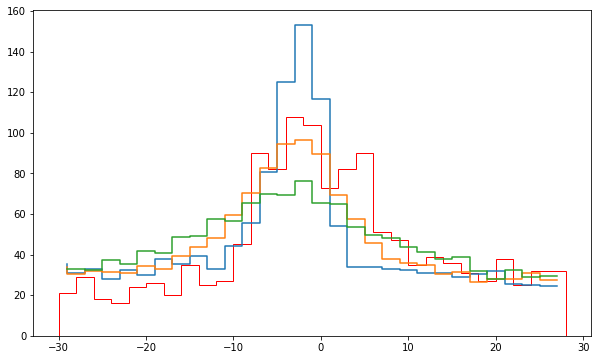

In [3]:
from lib.histdist import distfit, model_rgb, distance_to_bump
import scipy.signal

obsdir = rootpath+"sample/rgb/yu/"
moddir = rootpath+"sample/rgb/mist/"
xobs, yobs = apk["teff"], apk["numax"]
xpdv, ypdv = mist['teff'], mist['numax']
eobs = apk["e_teff"]/apk["teff"]
bump_obs = np.load(obsdir+"numax_bump.npy")
bump_pdv = np.load(moddir+"numax_bump.npy")
distance = 'vertical'
hist_model = model_rgb()
bins = np.arange(-30, 30, 2.0)


hdist_obs, xobs, yobs = distance_to_bump(xobs, yobs, bump_obs, distance=distance)
obj_obs = distfit(hdist_obs, hist_model, bins=bins)
obj_obs.fit(ifmcmc=False)
hdist_pdv, xpdv, ypdv = distance_to_bump(xpdv, ypdv, bump_pdv, distance=distance)
obj_pdv = distfit(hdist_pdv, hist_model, bins=bins)
obj_pdv.fit(ifmcmc=False)
    
Ndata = xpdv.shape[0]

# tied to model_heb
weight = np.zeros(obj_obs.histx.shape, dtype=bool)
sigma, x0 = obj_obs.para_fit[0], obj_obs.para_fit[1]
idx = (obj_obs.histx >= x0-4*sigma) & (obj_obs.histx <= x0+4*sigma)
weight[idx] = True

eobs_cut = eobs[np.abs(hdist_obs) <= 3*sigma]
    
if distance=="vertical":
    fy1_base = np.random.normal(size=Ndata) * 10.0**scipy.signal.resample(np.log10(eobs_cut), Ndata)
    fp1 = ypdv*fy1_base
    # fp1 = fy1_base
    fy2_base = np.random.normal(size=Ndata)
    fp2 = ypdv*fy2_base

fig, axes = plt.subplots(figsize=(10,6), nrows=1,ncols=1, squeeze=False)
axes = axes.reshape(-1)


def model(theta):#, obj_obs, xpdv, ypdv):

    # theta[0]: offset in distance
    # theta[1]: perturb

    # disturb with artificial scatter
    # xdata, ydata = (xpdv + xpdv*(fx2_base*theta[1])), (ypdv + ypdv*(fy2_base*theta[1]))

    hdist = hdist_pdv + fp1 + fp2*theta
    obj = distfit(hdist, hist_model, bins=obj_obs.bins)

    # normalize the number of points in the weighted region
    if np.sum(obj.histy[weight])!=0:
        number_reduction_factor = 1. / np.sum(obj.histy[weight])*np.sum(obj_obs.histy[weight])
    else:
        number_reduction_factor = 0.
    histy = obj.histy * number_reduction_factor
    return histy, hdist, number_reduction_factor


# Obs
axes[0].hist(hdist_obs, color='red', bins=bins, histtype='step')

# Model
for s in [0., 0.1, 0.2]:
    hdist = hdist_pdv + fp1 + fp2*s
    histy, _, _ = model(s)
    axes[0].step(obj_obs.histx, histy)